In [247]:
import os
import csv
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [225]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))
adata_betas = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_mroi_betas.h5ad'))
adata_betas_l1 = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_mroi_betas_l1.h5ad'))

In [246]:
age_str = '12w'
df_bayes_crypt = pd.read_csv('../data/fig4_bayes_factors_crypt_gradient_12w.csv')

# Read in mapping of ENSEMBL to common
df_map = pd.read_csv('../data/Gene_names_mm.txt', sep='_', header=None, names=['common'])
df_bayes_crypt = df_bayes_crypt.join(df_map, how='left', on='gene')

### Fig. 4f: heatmap visualization of gradient genes

In [4]:
# Specify a color mapping between gene functional annotations and colors:
broad_fun_colors = {
    'Extracellular matrix': matplotlib.cm.get_cmap('tab20')(0.70),
    'Cell polarity and cytoskeleton': matplotlib.cm.get_cmap('tab20')(0.75),
    'Ion transport': matplotlib.cm.get_cmap('tab20')(0.2),
    'Oxireductase activity': matplotlib.cm.get_cmap('tab20')(0.25),
    'Ribosome and protein translation': matplotlib.cm.get_cmap('tab20')(0.4),
    'RNA binding and processing': matplotlib.cm.get_cmap('tab20')(0.45),
    'DNA replication': matplotlib.cm.get_cmap('tab20')(0.5),
    'DNA repair': matplotlib.cm.get_cmap('tab20')(0.55),
}

bold_genes = ['Reln', 'Fgfr2', 'Msh2', 'Ezr', 'Gpa33', 'Krt8', 'Ceacam1']

In [5]:
def grad_gene_heatmap(df_bayes, region='any', age_str='12w', highlight_genes=None, gene_functions=None,
                      bold_genes=None,
                      xlabels=True, cbar_pos=(0.02, 0.8, 0.05, 0.18)):
    
    regions_ordered = ['Proximal', 'Middle', 'Distal']
    aars_ordered = ['mean_subcrypt', 'mean_base', 'mean_mid', 'mean_apex']
    
    # genes with gradient behavior in any region (union)
    if region == 'any':
        grad_genes_any = df_bayes['common'][df_bayes['grad_gene']].unique()
        inds_grad = df_bayes['common'].isin(grad_genes_any)
        
    # genes with gradient behavior in all regions (intersection)
    elif region == 'all':
        grad_genes_all = df_bayes['common'].unique()
        for r in regions_ordered:
            inds_grad_r = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==r)
            grad_genes_r = df_bayes['common'][inds_grad_r].values
            grad_genes_all = np.intersect1d(grad_genes_r, grad_genes_all)

        inds_grad = df_bayes['common'].isin(grad_genes_all)
    
    # genes with gradient behavior in a single region
    else:
        inds_grad = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==region)
    
    
    # Include AARs from all regions
    if region == 'any' or region == 'all':
        df_mean_betas = None
        
        for r in regions_ordered:
            inds_grad_in = np.logical_and(inds_grad, df_bayes['Region']==r)
            
            df_mean_betas_r = df_bayes.loc[inds_grad_in][aars_ordered]
            df_mean_betas_r.index = df_bayes['common'][inds_grad_in]
            df_mean_betas_r.columns = ['%s %s' % (r, a) for a in aars_ordered]
            
            if df_mean_betas is None:
                df_mean_betas = df_mean_betas_r
            else:
                df_mean_betas = df_mean_betas.join(df_mean_betas_r, how='outer')
                            
        # reorder columns
        c_order = []
        for a in aars_ordered:
            for r in regions_ordered:
                c_order.append('%s %s' % (r, a))
        df_mean_betas = df_mean_betas[c_order]
                
    # Include only AARs from specified region
    else:
        df_mean_betas = df_bayes.loc[inds_grad][aars_ordered]
        df_mean_betas.index = df_bayes['common'][inds_grad]
    
    if len(df_mean_betas) == 0:
        print('No gradient genes found for region "%s"' % region)
        return None
    
    # scale mean betas for each gene between 0 and 1 across AARs+regions
    df = df_mean_betas.T - df_mean_betas.T.min()
    df_mean_betas_scaled = (df / df.max()).T
    
    # if gene functions provided, color rows accordingly:
    if gene_functions is not None:
        row_colors = []
        for g in df_mean_betas_scaled.index:
            if g in gene_functions.index:
                row_colors.append(broad_fun_colors[gene_functions.loc[g]])
            else:
                row_colors.append((1,1,1,1))
        row_colors = pd.Series(index=df_mean_betas_scaled.index, data=row_colors)
 
    # create clustermap without dendrogram
    cg = sns.clustermap(data=df_mean_betas_scaled, 
                        metric='cityblock', method='average',
                        row_cluster=True, col_cluster=False,
                        row_colors=row_colors,
                        cbar_kws={'label':r'normalized mean $\beta$'},
                        cbar_pos=cbar_pos,
                        cmap = 'YlGnBu_r',
                        figsize=(6, 2 + 30 * len(df_mean_betas_scaled) / 321))
    cg.ax_row_dendrogram.set_visible(False)
    
    # legend for row colors
    if gene_functions is not None and (region == 'any' or region == 'all'):
        handles = [Patch(facecolor=broad_fun_colors[name]) for name in broad_fun_colors]
        plt.legend(handles, broad_fun_colors, title='Gene function',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    
    # list of genes in the order they are plotted
    row_inds_ordered = cg.dendrogram_row.reordered_ind
    df_ordered = df_mean_betas_scaled.iloc[row_inds_ordered, :]
    
    if df_ordered.iloc[0,0] > df_ordered.iloc[-1,0]:
        cg.ax_heatmap.invert_yaxis()
        cg.ax_row_dendrogram.invert_yaxis()
        cg.ax_row_colors.invert_yaxis()
    
    if region == 'all':
        cg.ax_heatmap.set_title('All regions, %s (N=%d gradient genes)' % (age_str, len(df_mean_betas_scaled)))
    elif region == 'any':
        cg.ax_heatmap.set_title('Any region, %s (N=%d gradient genes)' % (age_str, len(df_mean_betas_scaled)))
    else:
        cg.ax_heatmap.set_title('%s, %s (N=%d gradient genes)' % (region, age_str, len(df_mean_betas_scaled)))
        
    # if specified, only label highlighted genes on y-axis
    if highlight_genes is not None:
        yticks, yticklabels = [],[]
        row_inds_ordered = cg.dendrogram_row.reordered_ind
        
        for y,g in enumerate(df_mean_betas_scaled.index[row_inds_ordered]):
            if g in highlight_genes:
                yticks.append(y)
                yticklabels.append(g)
        
        # Add leading spaces to densely clustered labels, in order to stagger them
        space_char = '  '
        for i, (y,g) in enumerate(zip(yticks, yticklabels)):
            if i>0 and yticks[i-1] == y-1 and not yticklabels[i-1].startswith(space_char):
                if yticks[i+1] == y+1:
                    spacer = space_char * np.maximum(len(yticklabels[i-1]), len(yticklabels[i+1]))
                else:
                    spacer = space_char * len(yticklabels[i-1])
                yticklabels[i] = spacer + g
        
        cg.ax_heatmap.set_yticks(yticks)
        cg.ax_heatmap.set_yticklabels(yticklabels, fontsize=9)
    
    # optionally, turn off x ticks/labels (for multi-row plots)
    if not xlabels:
        cg.ax_heatmap.set_xticks([])
        cg.ax_heatmap.set_xticklabels([])
    
    cg.ax_heatmap.set_ylabel('')
    
    # ensure y ticklabels are always horizontal and x ticklabels always vertical
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
    plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90) 
    
    # bold selected genes on y-axis
    if bold_genes is not None:
        for i, yl in enumerate(cg.ax_heatmap.get_yticklabels()):
            if yl.get_text().strip() in bold_genes:
                cg.ax_heatmap.get_yticklabels()[i].set_weight('bold')
    
    return cg, df_ordered

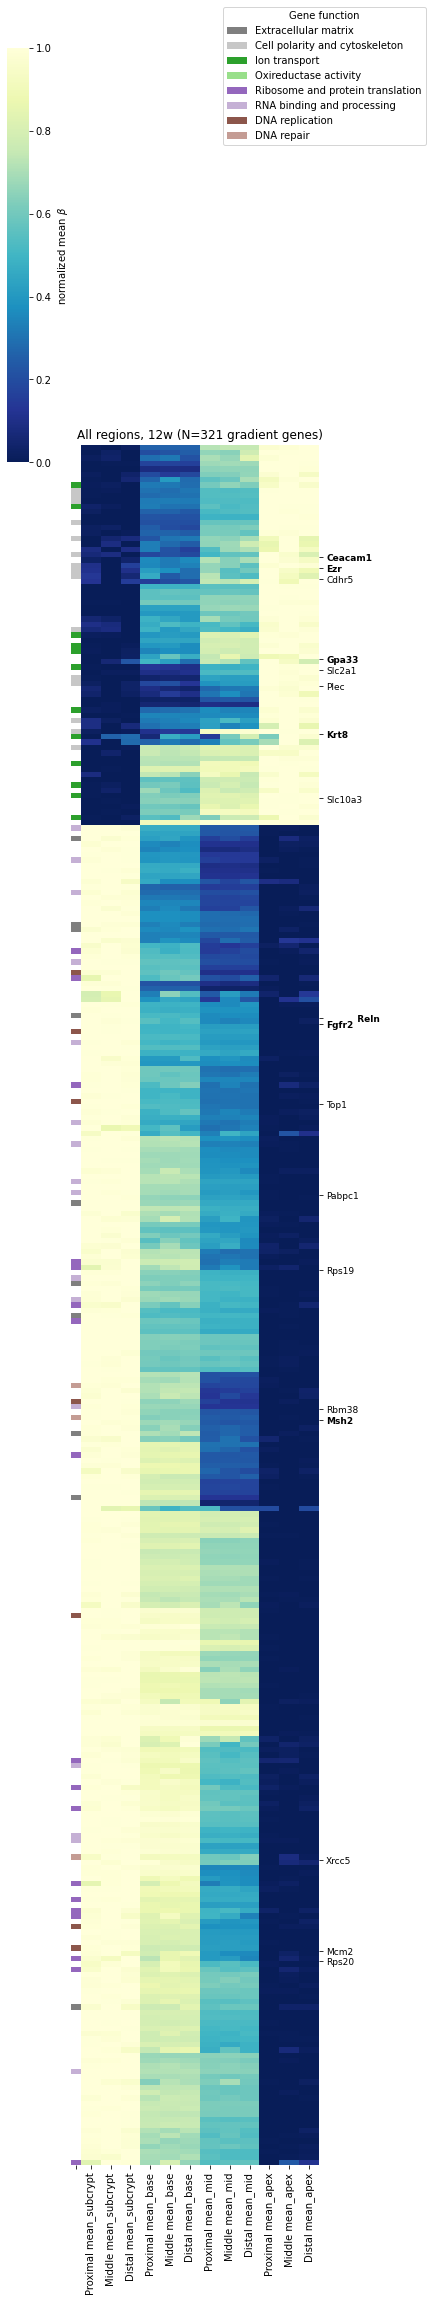

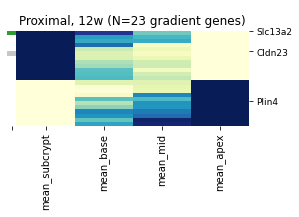

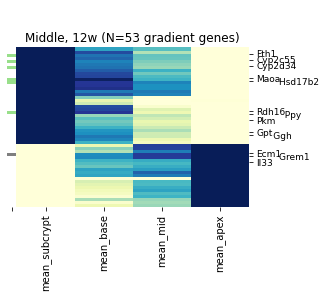

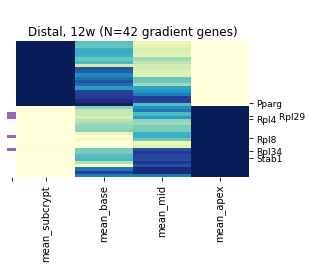

In [6]:
f_annot_file = '../data/fig4_gradient_genes_annotated_FC.txt'
df_annot = pd.read_csv(f_annot_file, header=0, index_col=0, sep='\t')

# genes mentioned in text
highlight_genes = ['Ceacam1', 'Ezr', 'Gpa33', 'Krt8', 'Reln', 'Fgfr2', 'Top1', 
                   'Mcm2', 'Msh2', 'Xrcc5', 'Rbm38', 'Pabpc1', 'Rps19', 'Rps20', 
                   'Cdhr5', 'Plec', 'Slc2a1', 'Slc10a3']

# Genes gradient across all colon regions
cg, df_all = grad_gene_heatmap(df_bayes_crypt, 'all', highlight_genes=highlight_genes, 
                               gene_functions=df_annot['Broad functional annotation'].dropna(), 
                               bold_genes=bold_genes)
plt.show()

# Genes exclusively gradient in each colon region
ex_grad_genes = []
for g in df_bayes_crypt['common'].unique():
    n_grad_reg = df_bayes_crypt[df_bayes_crypt['common']==g]['grad_gene'].sum()
    if n_grad_reg == 1:
        ex_grad_genes.append(g)
ex_grad_genes = np.array(ex_grad_genes)
df_bayes_crypt_ex = df_bayes_crypt[df_bayes_crypt['common'].isin(ex_grad_genes)]

for r in ['Proximal', 'Middle', 'Distal']:
    f_annot_file = '../data/fig4_gradient_genes_annotated_FC_%s.txt' % r
    df_annot = pd.read_csv(f_annot_file, header=0, index_col=0, sep='\t')

    cg, df_reg = grad_gene_heatmap(df_bayes_crypt_ex, r, highlight_genes=df_annot.index,
                                   gene_functions=df_annot['Broad functional annotation'].dropna(), 
                                   bold_genes=bold_genes,
                                   cbar_pos=None)
    plt.subplots_adjust(left=0.1, right=0.8, bottom=0.5, top=0.9)
    plt.show()

### Fig 4g: KEGG enrichment of gradient genes

2023-09-20 10:46:28,351 [INFO] Run: KEGG_2019_Mouse 
2023-09-20 10:46:29,569 [INFO] Run: GO_Biological_Process_2023 
2023-09-20 10:46:31,064 [INFO] Run: GO_Cellular_Component_2023 
2023-09-20 10:46:32,408 [INFO] Run: GO_Molecular_Function_2023 
2023-09-20 10:46:33,719 [INFO] Done.
2023-09-20 10:46:34,193 [INFO] Run: KEGG_2019_Mouse 
2023-09-20 10:46:35,474 [INFO] Run: GO_Biological_Process_2023 
2023-09-20 10:46:36,795 [INFO] Run: GO_Cellular_Component_2023 
2023-09-20 10:46:38,239 [INFO] Run: GO_Molecular_Function_2023 
2023-09-20 10:46:39,444 [INFO] Done.


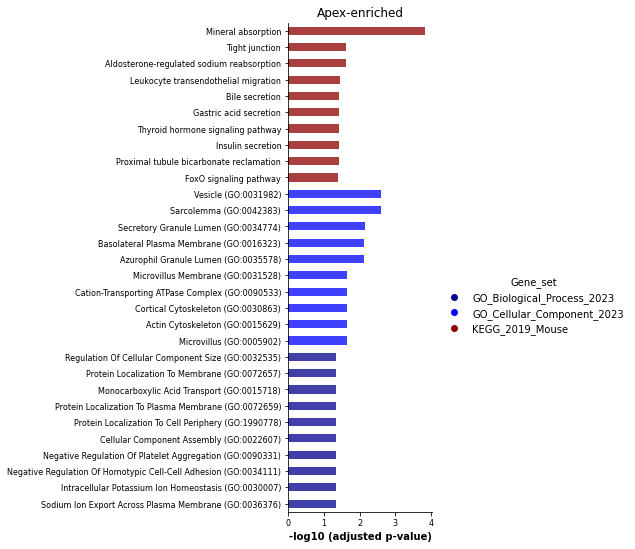

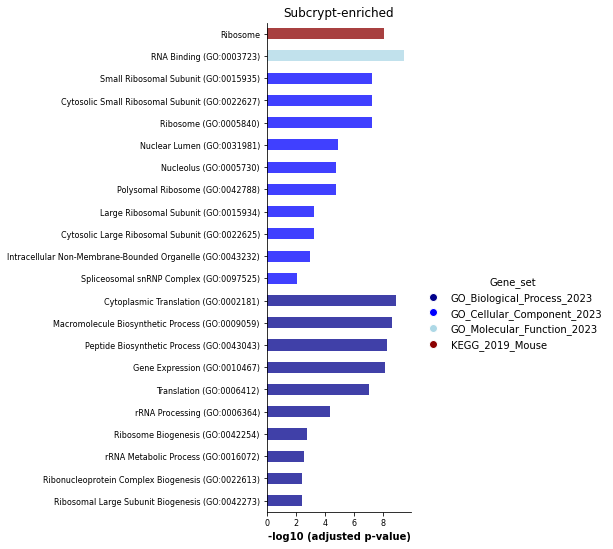

In [38]:
import gseapy as gp

# Enrichr computes enrichment of a gene set by three methods:
# 1. Fisher exact test
# 2. Correction to Fisher exact test based on null distribution from many random gene sets
# 3. Combination of p-value from (1) and z-score of (2)
def grad_gene_enrichr(df_bayes, region='all', age='12w'):
    regions_ordered = ['Proximal', 'Middle', 'Distal']
    aars_ordered = ['mean_subcrypt', 'mean_base', 'mean_mid', 'mean_apex']
    
    # genes with gradient behavior in any region (union)
    if region == 'any':
        grad_genes_any = df_bayes['common'][df_bayes['grad_gene']].unique()
        inds_grad = df_bayes['common'].isin(grad_genes_any)
        
    # genes with gradient behavior in all regions (intersection)
    elif region == 'all':
        grad_genes_all = df_bayes['common'].unique()
        for r in regions_ordered:
            inds_grad_r = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==r)
            grad_genes_r = df_bayes['common'][inds_grad_r].values
            grad_genes_all = np.intersect1d(grad_genes_r, grad_genes_all)

        inds_grad = df_bayes['common'].isin(grad_genes_all)
    
    # genes with gradient behavior in a single region
    else:
        inds_grad = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==region)
    
    
    # Include AARs from all regions
    if region == 'any' or region == 'all':
        df_mean_betas = None
        
        for r in regions_ordered:
            inds_grad_in = np.logical_and(inds_grad, df_bayes['Region']==r)
            
            df_mean_betas_r = df_bayes.loc[inds_grad_in][aars_ordered]
            df_mean_betas_r.index = df_bayes['common'][inds_grad_in]
            df_mean_betas_r.columns = ['%s %s' % (r, a) for a in aars_ordered]
            
            if df_mean_betas is None:
                df_mean_betas = df_mean_betas_r
            else:
                df_mean_betas = df_mean_betas.join(df_mean_betas_r, how='outer')
                            
        # reorder columns
        c_order = []
        for a in aars_ordered:
            for r in regions_ordered:
                c_order.append('%s %s' % (r, a))
        df_mean_betas = df_mean_betas[c_order]
                
    # Include only AARs from specified region
    else:
        df_mean_betas = df_bayes.loc[inds_grad][aars_ordered]
        df_mean_betas.index = df_bayes['common'][inds_grad]
    
    if len(df_mean_betas) == 0:
        print('No gradient genes found for region "%s"' % region)
        return None
    
    # Separate genes into apex-enriched and subcrypt-enriched
    apex_enriched = df_mean_betas.index[df_mean_betas.iloc[:, -1] > df_mean_betas.iloc[:, 0]]
    subcrypt_enriched = df_mean_betas.index[df_mean_betas.iloc[:, 0] > df_mean_betas.iloc[:, -1]]
        
    enr_apex = gp.enrichr(gene_list=list(apex_enriched.values),
                          gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2023',
                                     'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                          background=list(df_bayes['common'].unique()),
                          outdir=None,
                          verbose=True)
    df_apex = enr_apex.results
    
    enr_subcrypt = gp.enrichr(gene_list=list(subcrypt_enriched.values),
                              gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2023',
                                     'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                              background=list(df_bayes['common'].unique()),
                              outdir=None,
                              verbose=True)
    df_subcrypt = enr_subcrypt.results
    
    #print(df_apex[df_apex['Adjusted P-value'] < 0.05])
    #print(df_subcrypt[df_subcrypt['Adjusted P-value'] < 0.05])

    ax_apex = gp.barplot(enr_apex.results,
                  column="Adjusted P-value",
                  group='Gene_set',
                  size=5,
                  top_term=10,
                  figsize=(8,9),
                  color=['darkblue', 'blue', 'darkred']
                        )
    ax_apex.tick_params(axis='both', which='major', labelsize=8)
    ax_apex.set_title('Apex-enriched', fontsize=12)
    ax_apex.set_xlabel('-log10 (adjusted p-value)', fontsize=10)
    
    plt.subplots_adjust(left=0.45, right=0.7)
    plt.savefig('fig4_gradgenes_apex_kegg_go.svg')
    
    ax_subcrypt = gp.barplot(enr_subcrypt.results,
                  column="Adjusted P-value",
                  group='Gene_set',
                  size=5,
                  top_term=10,
                  figsize=(8,9),
                  color=['darkblue', 'blue', 'lightblue', 'darkred']
                        )
    ax_subcrypt.tick_params(axis='both', which='major', labelsize=8)
    ax_subcrypt.set_title('Subcrypt-enriched', fontsize=12)
    ax_subcrypt.set_xlabel('-log10 (adjusted p-value)', fontsize=10)
    
    plt.subplots_adjust(left=0.45, right=0.7)
    plt.savefig('fig4_gradgenes_subcrypt_kegg_go.svg')
    
    
grad_gene_enrichr(df_bayes_crypt, region='all')

### Fig 4g: show connection between cell abundance and cell type specificity of gradient genes

In [22]:
bf_dir = '/Users/adaly/Documents/mouse_colon/bayes_factors_crypt_gradient_12w_cellassoc'
df_cellassoc = pd.read_csv(os.path.join(bf_dir, 'crypt_gradient_genes_12w_sig_cellassoc.csv'))
df_cellassoc['celltype'][df_cellassoc['celltype'] == 'Myocyte'] = 'SMC'

abund_ctypes = ['Colonocyte', 'Goblet', 'Tuft', 'TA', 
                'Cycling', 'Enteroendocrine', 'Stem',
                'Mesothelial', 'Macrophage',
                'Fibroblast', 'Vascular', 'Lymphatic','SMC']

/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_73339/3577771356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellassoc['celltype'][df_cellassoc['celltype'] == 'Myocyte'] = 'SMC'


In [61]:
# Pick genes per celltype (for now)
n_per = 3
genes_per_ctype = {}
ens_per_ctype = {}
sel_genes = []

for ct in abund_ctypes:
    df_ct = df_cellassoc[df_cellassoc['celltype']==ct]
    df_ct.sort_values('BF', ascending=False, inplace=True)
    
    genes_per_ctype[ct] = [] 
    ens_per_ctype[ct] = []
    
    for g,e in zip(df_ct['gene_symbol'].values[:3], df_ct['ENSEMBL'].values[:3]):
        if not g in sel_genes:
            genes_per_ctype[ct].append(g)
            ens_per_ctype[ct].append(e)
            sel_genes.append(g)

/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_73339/3480541649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ct.sort_values('BF', ascending=False, inplace=True)


In [172]:
genes_per_ctype = {
    'Stem': ['Top1', 'Fance', 'Xrcc5', 'Eef1a1', 'Rps9', 'Rps24', 'Set', 'Smyd2', 'Mettl1', 'Stk38'],
    'Goblet': ['Ezr', 'Ceacam1', 'Cldn3', 'Slc26a3', 'Slc6a8'],
    'Mesothelial': ['Reln'],
    'Cycling': ['Fgfr2']
}

ens_per_ctype = {}
for ct, gene_list in genes_per_ctype.items():
    ens_per_ctype[ct] = []
    
    for g in gene_list:
        df = df_cellassoc[df_cellassoc['gene_symbol']==g]
        ens_per_ctype[ct].append(df["ENSEMBL"].values[0])
        
print(ens_per_ctype)

{'Stem': ['ENSMUSG00000070544.6', 'ENSMUSG00000007570.15', 'ENSMUSG00000026187.8', 'ENSMUSG00000037742.14', 'ENSMUSG00000006333.14', 'ENSMUSG00000025290.16', 'ENSMUSG00000054766.13', 'ENSMUSG00000026603.13', 'ENSMUSG00000006732.14', 'ENSMUSG00000024006.16'], 'Goblet': ['ENSMUSG00000052397.8', 'ENSMUSG00000074272.10', 'ENSMUSG00000070473.4', 'ENSMUSG00000001225.12', 'ENSMUSG00000019558.14'], 'Mesothelial': ['ENSMUSG00000042453.14'], 'Cycling': ['ENSMUSG00000030849.18']}


In [227]:
def get_exp_sig_dfs(subdir):
    df_exp = []
    df_sig = []

    for mroi in crypt_mrois:
        sig_row, exp_row = [],[]

        if mroi == 'crypt apex' or mroi == 'crypt mid':
            bf_file = os.path.join(bf_dir, subdir, mroi+'.csv')
        if mroi == 'crypt base':
            bf_file = os.path.join(bf_dir, subdir, 'crypt base and mid.csv')
        if mroi == 'sub-crypt':
            bf_file = os.path.join(bf_dir, subdir, 'crypt base.csv')
        df = pd.read_csv(bf_file, index_col=0)

        for ct in genes_per_ctype.keys():
            for ens in ens_per_ctype[ct]:
                if 'mean(%s)' % ct in df.columns:
                    bf = df.loc[ens, 'BF(%s vs rest)' % ct]
                    beta = df.loc[ens, 'mean(%s)' % ct]

                    sig_row.append(bf)
                    exp_row.append(beta)
                else:
                    sig_row.append(1)
                    exp_row.append(0)

        df_exp.append(exp_row)
        df_sig.append(sig_row)

    df_exp = pd.DataFrame(df_exp, index=crypt_mrois, 
                          columns=np.concatenate([genes_per_ctype[c] for c in genes_per_ctype.keys()]))
    df_sig = pd.DataFrame(df_sig, index=crypt_mrois, 
                          columns=np.concatenate([genes_per_ctype[c] for c in genes_per_ctype.keys()]))
    print(df_sig.values.max())
    df_sig = df_sig.clip(upper=20)
    df_sig = np.log10(df_sig)
    print(df_sig.values.max())
    
    return df_exp, df_sig

df_exp_p, df_sig_p = get_exp_sig_dfs('Proximal')
df_exp_m, df_sig_m = get_exp_sig_dfs('Middle')
df_exp_d, df_sig_d = get_exp_sig_dfs('Distal')
df_exp_12, df_sig_12 = get_exp_sig_dfs('12w')

df_exp_max, df_sig_max = df_exp_p.copy(), df_sig_p.copy()
for dfe, dfs in zip([df_exp_m, df_exp_d], [df_sig_m, df_sig_d]):    
    for x in dfs.index:
        for y in dfs.columns:
            if dfs.loc[x,y] > df_sig_max.loc[x,y]:
                #print(reg,x,y)
                df_sig_max.loc[x,y] = dfs.loc[x,y]
                df_exp_max.loc[x,y] = dfe.loc[x,y]

2.327062109169872
0.36680797473915144
inf
1.3010299956639813
19.1161696871604
1.2814008769371814
2.636625699969984
0.4210484809593557


/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


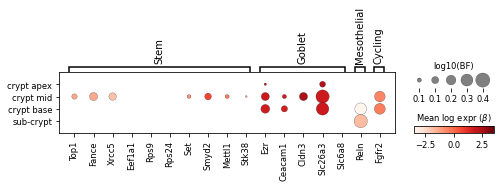

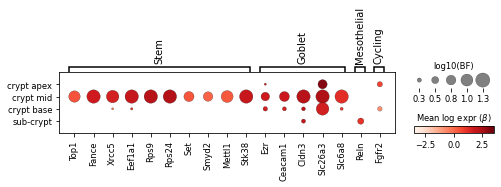

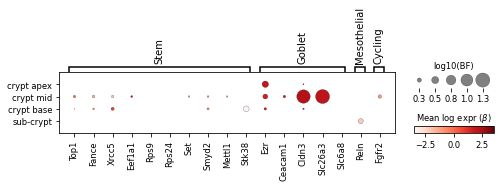

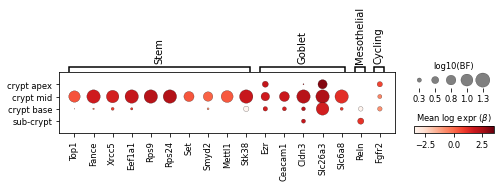

In [233]:
def plot_scores_dotplot(df, df_size, genes_per_ctype):
    obs = pd.DataFrame(df.index, index = df.index, columns = ['Cell type']).astype("category")
    mod_anndata = sc.AnnData(df, obs, dtype=np.float32)
    
    #df_size = df_size.round(0).astype(int)
    
    size_title = 'log10(BF)'
    colorbar_title = r"Mean log expr ($\beta$)"
        
    ax_dict = sc.pl.dotplot(mod_anndata, show=False, 
                            var_names = genes_per_ctype, groupby='Cell type',
                            dot_size_df = df_size,
                            dot_color_df = df,
                            colorbar_title = colorbar_title,
                            size_title = size_title,
                            vmin=-3.5, vmax=3.5,
                           )
    
    size_legend_ax = ax_dict['size_legend_ax']
    size_legend_ax.clear()
    
    dot_max, dot_min = df_size.values.max(), 0
    largest_dot, smallest_dot = 200, 0
    size_exponent = 1.5
    
    diff = dot_max - dot_min
    '''print(diff)
    if 0.3 < diff <= 0.6:
        step = 0.1
    elif diff <= 0.3:
        step = 0.05
    else:
        step = 0.2'''
    step = diff/5
    # a descending range that is afterwards inverted is used
    # to guarantee that dot_max is in the legend.
    size_range = np.arange(dot_max, dot_min, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        dot_range = dot_max - dot_min
        size_values = (size_range - dot_min) / dot_range
    else:
        size_values = size_range

    size = size_values**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot

    # plot size bar
    size_legend_ax.scatter(
        np.arange(len(size)) + 0.5,
        np.repeat(0, len(size)),
        s=size,
        color='gray',
        edgecolor='black',
        linewidth=0.2,
        zorder=100,
    )
    size_legend_ax.set_xticks(np.arange(len(size)) + 0.5)
    labels = [
        "{}".format(np.round(x, decimals=1)) for x in size_range
    ]
    size_legend_ax.set_xticklabels(labels, fontsize='small')
    
    ymax = size_legend_ax.get_ylim()[1]
    size_legend_ax.set_ylim(-1.05 - largest_dot * 0.003, 4)
    size_legend_ax.set_title(size_title, y=ymax + 0.45, size='small')

    xmin, xmax = size_legend_ax.get_xlim()
    size_legend_ax.set_xlim(xmin - 0.15, xmax + 0.5)
    
    plt.subplots_adjust(bottom=0.27)
    
    return ax_dict

plot_scores_dotplot(df_exp_p, df_sig_p, genes_per_ctype)
plot_scores_dotplot(df_exp_m, df_sig_m, genes_per_ctype)
plot_scores_dotplot(df_exp_d, df_sig_d, genes_per_ctype)
plot_scores_dotplot(df_exp_max, df_sig_max, genes_per_ctype)
#plt.savefig('fig4g_dots.svg')

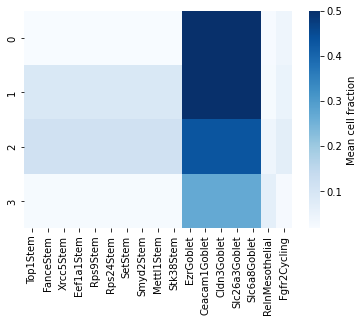

In [237]:
# Heatmap visualization of cell abundance in each MROI:
crypt_mrois = ['crypt apex', 'crypt mid', 'crypt base', 'sub-crypt']
obs_12w = adata.obs[adata.obs.Age == '12w']
obs_12w = obs_12w[obs_12w.annotation.isin(crypt_mrois)]

data = {}
for mroi in crypt_mrois:
    row = obs_12w.loc[obs_12w.annotation==mroi, genes_per_ctype.keys()].mean(axis=0)
    data[mroi] = row
df_data = pd.DataFrame(data).T

df_data2 = {}
for ct in df_data.columns:
    for g in genes_per_ctype[ct]:
        df_data2[g+ct] = df_data[ct].values
df_data2 = pd.DataFrame(df_data2)

sns.heatmap(df_data2, cmap="Blues", vmax=0.5, cbar_kws={'label':'Mean cell fraction'})
plt.savefig('fig4g_bars.svg')

In [251]:
# Dotplot showing vanilla splotch beta estimates for selected crypt gradient genes
gene_to_ens = {
    'Top1': 'ENSMUSG00000070544.6',
    'Fance': 'ENSMUSG00000007570.15',
    'Xrcc5': 'ENSMUSG00000026187.8',
    'Eef1a1': 'ENSMUSG00000037742.14',
    'Rps9': 'ENSMUSG00000006333.14',
    'Rps24': 'ENSMUSG00000025290.16',
    'Set': 'ENSMUSG00000054766.13',
    'Smyd2': 'ENSMUSG00000026603.13',
    'Mettl1': 'ENSMUSG00000006732.14',
    'Stk38': 'ENSMUSG00000024006.16',
    'Reln': 'ENSMUSG00000042453.14',
    'Fgfr2': 'ENSMUSG00000030849.18',
    'Ezr': 'ENSMUSG00000052397.8',
    'Ceacam1': 'ENSMUSG00000074272.10',
    'Cldn3': 'ENSMUSG00000070473.4',
    'Slc26a3': 'ENSMUSG00000001225.12',
    'Slc6a8': 'ENSMUSG00000019558.14',
    
    'Ppy':'',
    'Fabp2':'',
    'Ugt2b5':''
}

enrichment = {
    'SUB-CRYPT': ['Top1', 'Fance', 'Xrcc5', 'Eef1a1', 'Rps9', 'Rps24', 'Set', 'Smyd2',
                  'Mettl1', 'Stk38', 'Reln', 'Fgfr2'],
    'APEX': ['Ezr', 'Ceacam1', 'Cldn3', 'Slc26a3', 'Slc6a8']
}

In [252]:
def mroi_dotplot(df, df_size, colorbar_title, size_title, 
                 delta=0.1, enrichment=None, vmin=-2.5, vmax=2.5, cmap='Reds', figsize=(8,3)):
    obs = pd.DataFrame(df.index, index = df.index, columns = ['MROI']).astype("category")
    mod_anndata = sc.AnnData(df, obs, dtype=np.float32)
            
    if enrichment == None:
        enrichment = mod_anndata.var_names
                
    ax_dict = sc.pl.dotplot(mod_anndata, show=False, 
                            var_names = enrichment, groupby='MROI',
                            var_group_rotation = 0,
                            dot_size_df = df_size+delta, # small amount added to df_size to make 0's show up
                            dot_color_df = df,
                            colorbar_title = colorbar_title,
                            size_title = size_title,
                            vmin=vmin, vmax=vmax,
                            figsize=figsize,
                            cmap=cmap
                           )
    
    size_legend_ax = ax_dict['size_legend_ax']
    size_legend_ax.clear()
    
    dot_max, dot_min = df_size.values.max(), 0
    largest_dot, smallest_dot = 200, 10
    size_exponent = 1.5
    
    diff = dot_max - dot_min
    step = diff/4
    # a descending range that is afterwards inverted is used
    # to guarantee that dot_max is in the legend.
    size_range = np.arange(dot_max, dot_min-step, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        dot_range = dot_max - dot_min
        size_values = (size_range - dot_min) / dot_range
    else:
        size_values = size_range

    size = size_values**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot

    # plot size bar
    size_legend_ax.scatter(
        np.arange(len(size)) + 0.5,
        np.repeat(0, len(size)),
        s=size,
        color='gray',
        edgecolor='black',
        linewidth=0.2,
        zorder=100,
    )
    size_legend_ax.set_xticks(np.arange(len(size)) + 0.5)
    labels = [
        "{}".format(np.round(x, decimals=1)) for x in size_range
    ]
    size_legend_ax.set_xticklabels(labels, fontsize='small')
    
    ymax = size_legend_ax.get_ylim()[1]
    size_legend_ax.set_ylim(-1.05 - largest_dot * 0.003, 4)
    size_legend_ax.set_title(size_title, y=ymax + 0.45, size='small')

    xmin, xmax = size_legend_ax.get_xlim()
    size_legend_ax.set_xlim(xmin - 0.15, xmax + 0.5)
    
    plt.subplots_adjust(bottom=0.27, top=0.82)
    
    return ax_dict

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

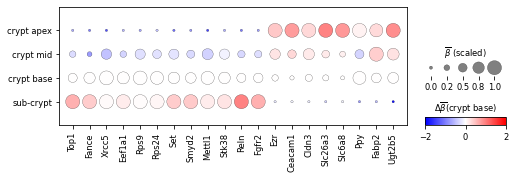

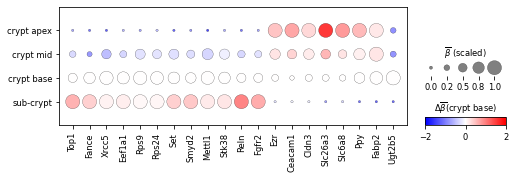

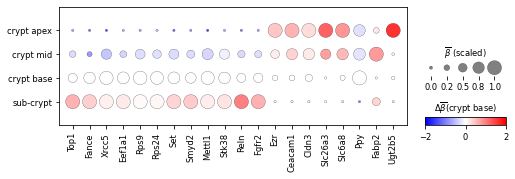

In [253]:
plot_dir = 'fig3_v2'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

age = '12w'
for reg in ['Proximal', 'Middle', 'Distal']:
    adata_reg = adata_betas[adata_betas.obs.condition=='%s BL6WT.%s' % (age, reg)]
    adata_reg.obs.index = adata_reg.obs.annotation

    crypt_mrois = ['crypt apex', 'crypt mid', 'crypt base', 'sub-crypt']

    df_mean = pd.DataFrame(index=crypt_mrois, columns=gene_to_ens.keys(), dtype=np.float64)
    df_std = pd.DataFrame(index=crypt_mrois, columns=gene_to_ens.keys(), dtype=np.float64)

    for mroi in crypt_mrois:
        for g, e in gene_to_ens.items():
            beta_mean = adata_reg[mroi, g].X[0,0]
            beta_std = adata_reg[mroi, g].layers['X_stds'][0,0]

            df_mean.loc[mroi, g] = beta_mean
            df_std.loc[mroi, g] = beta_std
    
    df_mean_scaled = df_mean - df_mean.min(axis=0)
    df_mean_scaled = df_mean_scaled / df_mean_scaled.max(axis=0)
    
    # Change in beta (Delta) relative to sub-crypt -- helps show changes in expression when scales vary
    df_delta = df_mean.copy()
    for i in range(len(df_delta)):
        df_delta.iloc[i,:] = df_mean.iloc[i,:]-df_mean.loc['crypt base',:]
        
    ax_dict = mroi_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(crypt base)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           enrichment=None,
                           vmin=-2, vmax=2, cmap='bwr'
                          )
    plt.savefig(os.path.join(plot_dir, 'fig3g_beta_gradient_%s.svg' % reg))
    
    #ax_dict['mainplot_ax'].set_title(reg)

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


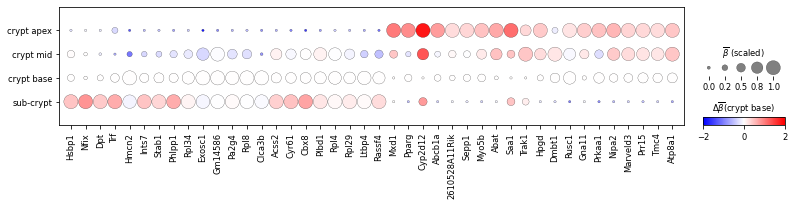

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


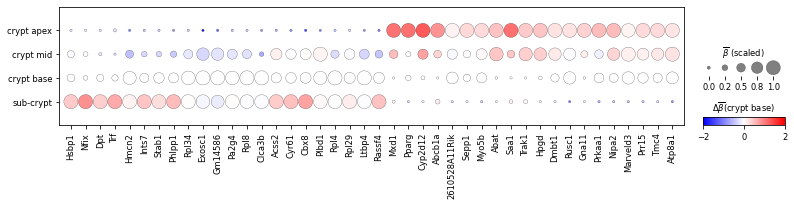

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


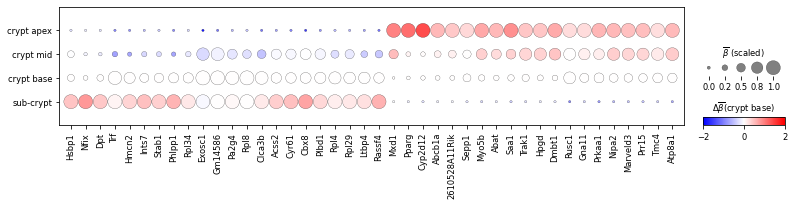

In [242]:
# Look at genes only gradient in one region for striking patterns:
grad_prox = ['Slc13a2','Saa3','Aldh1a1','Ugdh','Tmigd1','Cldn23','Atl2','Acaa1b','Ugt2b5',
             'Car2','Entpd5','Mgam2-ps','Swi5','Amt','Scml4','Timp3','Igfbp4','Plin4',
             'Csrp2bp','Sobp','Fam46c','Tubgcp2','Csrp1']
grad_mid = ['Mettl7b','Slc25a5','Fth1','Anxa3','Cyp2c55','Car1','Cyp2d34','Nlrp6','St3gal4',
            'Saa2','Maoa','Hsd17b2','Fos','Jun','Dpep1','AW112010','Hbegf','Fabp2','Pdzd7',
            'Ell2','Eno3','Rdh16','Ppy','Cdh1','Pkm','Tpsg1','Ifit1bl1','Tmem45b','Gpt',
            'Ggh','S100a6','Slc6a14','Eef1b2','Wfdc18','Kcnk3','Ecm1','Grem1','Impdh2','Il33',
            'Gm11410','Defb45','Abcb8','Rps28','Gm13567','Irf2bp2','Atf7','Nxpe2','Rps2',
            'Rack1','Akr7a5','Nrbp2','Nans','Pygb']
grad_dist = ['Hsbp1','Nfix','Dpt','Trf','Hmcn2','Ints7','Stab1','Phlpp1','Rpl34','Exosc1',
             'Gm14586','Pa2g4','Rpl8','Clca3b','Acss2','Cyr61','Cbx8','Plbd1','Rpl4', 'Rpl29',
             'Ltbp4','Rassf4','Mxd1','Pparg','Cyp2d12','Abcb1a','2610528A11Rik','Sepp1',
             'Myo5b','Abat','Saa1','Trak1','Hpgd','Dmbt1','Rusc1','Gna11','Prkaa1','Nipa2',
             'Marveld3','Prr15','Tmc4','Atp8a1']

grad_genes = grad_dist

for reg in ['Proximal', 'Middle', 'Distal']:
    adata_reg = adata_betas[adata_betas.obs.condition=='%s BL6WT.%s' % (age, reg)]
    adata_reg.obs.index = adata_reg.obs.annotation

    crypt_mrois = ['crypt apex', 'crypt mid', 'crypt base', 'sub-crypt']

    df_mean = pd.DataFrame(index=crypt_mrois, columns=grad_genes, dtype=np.float64)
    df_std = pd.DataFrame(index=crypt_mrois, columns=grad_genes, dtype=np.float64)

    for mroi in crypt_mrois:
        for g in grad_genes:
            beta_mean = adata_reg[mroi, g].X[0,0]
            beta_std = adata_reg[mroi, g].layers['X_stds'][0,0]

            df_mean.loc[mroi, g] = beta_mean
            df_std.loc[mroi, g] = beta_std
    
    df_mean_scaled = df_mean - df_mean.min(axis=0)
    df_mean_scaled = df_mean_scaled / df_mean_scaled.max(axis=0)
        
    # Change in beta (Delta) relative to sub-crypt -- helps show changes in expression when scales vary
    df_delta = df_mean.copy()
    for i in range(len(df_delta)):
        df_delta.iloc[i,:] = df_mean.iloc[i,:]-df_mean.loc['crypt base',:]
        
    ax_dict = mroi_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(crypt base)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           enrichment=None,
                           vmin=-2, vmax=2, cmap='bwr',
                           figsize=(13,3)
                          )
    plt.show()

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


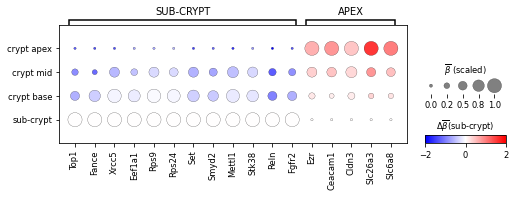

In [228]:
# As above but for level-1 betas
age = '12w'
adata_age = adata_betas_l1[adata_betas_l1.obs.condition==age]
adata_age.obs.index = adata_age.obs.annotation

crypt_mrois = ['crypt apex', 'crypt mid', 'crypt base', 'sub-crypt']

df_mean = pd.DataFrame(index=crypt_mrois, columns=gene_to_ens.keys(), dtype=np.float64)
df_std = pd.DataFrame(index=crypt_mrois, columns=gene_to_ens.keys(), dtype=np.float64)

for mroi in crypt_mrois:
    for g, e in gene_to_ens.items():
        beta_mean = adata_age[mroi, g].X[0,0]
        df_mean.loc[mroi, g] = beta_mean

df_mean_scaled = df_mean - df_mean.min(axis=0)
df_mean_scaled = df_mean_scaled / df_mean_scaled.max(axis=0)

# Change in beta (Delta) relative to sub-crypt -- helps show changes in expression when scales vary
df_delta = df_mean.copy()
for i in range(len(df_delta)):
    df_delta.iloc[i,:] = df_mean.iloc[i,:]-df_mean.loc['sub-crypt',:]

ax_dict = mroi_dotplot(df_delta, df_mean_scaled, 
                       colorbar_title=r'$\Delta\overline{\beta}$(sub-crypt)',
                       size_title=r'$\overline{\beta}$ (scaled)',
                       enrichment=enrichment,
                       vmin=-2, vmax=2, cmap='bwr'
                      )
plt.savefig(os.path.join(plot_dir, 'fig3g_beta_gradient_all.svg'))

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


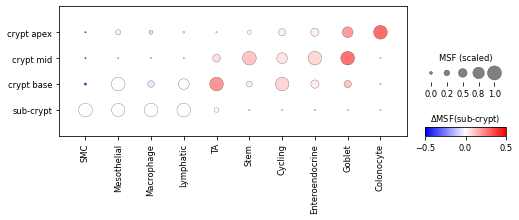

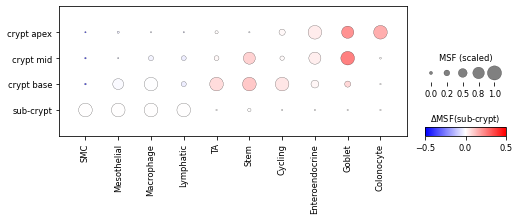

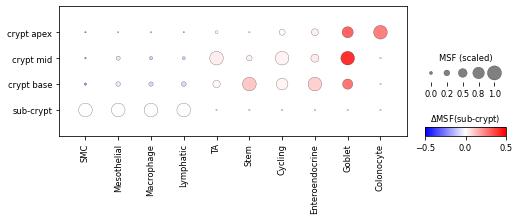

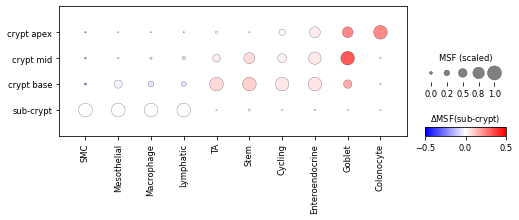

In [217]:
# Dotplot showing prevalence of each cell type in each MROI
sntypes = ['TA', 'SMC', 'Neuron', 'Mesothelial', 'Fibroblast', 'Cycling', 
           'Stem', 'Glia', 'Colonocyte', 'Vascular', 'Enteroendocrine', 
           'Tuft', 'T', 'Macrophage', 'Lymphatic', 'Goblet', 'B']

abund_ctypes = ['SMC', 'Mesothelial', 'Macrophage', 'Lymphatic',
                'TA', 'Stem', 'Cycling', 'Enteroendocrine',
                'Goblet', 'Colonocyte']

def mroi_cellcomp_dotplot(obs, age, reg=None):
    if reg is not None:
        obs_reg = obs[obs.Region==reg]
    else:
        obs_reg = obs
    obs_age = obs_reg[obs_reg.Age==age]
    obs_crypt = obs_age[obs_age.annotation.isin(crypt_mrois)]
    
    # Find celltypes abundant in at least one crypt MROI
    '''
    abund_ctypes = []
    for mroi in crypt_mrois:
        for ct in sntypes:
            if obs_crypt[ct][obs_crypt.annotation==mroi].mean() > 0.05 and ct not in abund_ctypes:
                abund_ctypes.append(ct)
    '''
                
    df_ct = pd.DataFrame(index=crypt_mrois, columns=abund_ctypes, dtype=np.float64)
    
    for mroi in crypt_mrois:
        for ct in abund_ctypes:
            df_ct.loc[mroi, ct] = obs_crypt[ct][obs_crypt.annotation==mroi].mean()
            
    df_ct_scaled = df_ct - df_ct.min()
    df_ct_scaled = df_ct_scaled / df_ct_scaled.max()
    
    # Change in MSF (Delta) relative to sub-crypt -- helps show changes in composition
    df_delta = df_ct.copy()
    for i in range(len(df_delta)):
        df_delta.iloc[i,:] = df_ct.iloc[i,:]-df_ct.loc['sub-crypt',:]
    
    ax_dict = mroi_dotplot(df_delta, df_ct_scaled,
                           colorbar_title=r'$\Delta$MSF(sub-crypt)',
                           size_title='MSF (scaled)',
                           vmin=-0.5, vmax=0.5,
                           delta=0.05,
                           cmap='bwr'
                          )
    plt.subplots_adjust(bottom=0.35, top=0.95)
    
for reg in ['Proximal', 'Middle', 'Distal']:
    mroi_cellcomp_dotplot(adata.obs, '12w', reg)
    plt.savefig(os.path.join(plot_dir, 'fig3g_cell_gradient_%s.svg' % reg))

mroi_cellcomp_dotplot(adata.obs, '12w')
plt.savefig(os.path.join(plot_dir, 'fig3g_cell_gradient_all.svg'))